In [48]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn as sk
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:
folder_path = 'C:/Users/Baile/source/repos/plant_classification/rice leaf diseases dataset'

In [3]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.jpg'):
            classes+=[dirname.split('\\')[-1]]
            paths+=[(os.path.join(dirname, filename))]

In [4]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

df=pd.DataFrame(columns=['path','class','label'])
df['path']=paths
df['class']=classes
df['label']=df['class'].map(normal_mapping)
print(len(df))

['Bacterialblight', 'Brownspot', 'Leafsmut']
3898


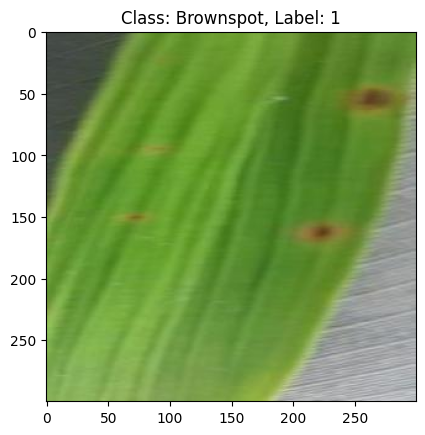

In [5]:
image_no = 1510
image_path = df['path'].iloc[image_no]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Class: {df['class'].iloc[image_no]}, Label: {df['label'].iloc[image_no]}")
plt.axis('on')  # Hide axes
plt.show()

In [6]:
print('number of samples: ', len(df['class']))
print('keys: ', list(df.keys()))
print('image shape: ', df.shape)
print('labels:', np.unique(df['class']))

number of samples:  3898
keys:  ['path', 'class', 'label']
image shape:  (3898, 3)
labels: ['Bacterialblight' 'Brownspot' 'Leafsmut']


In [7]:
# Load and preprocess the data
batch_size = 32
img_height = 300
img_width = 300
validation_split = 0.2

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=validation_split,
    labels='inferred',
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.


In [9]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=validation_split,
    labels='inferred',
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4684 files belonging to 3 classes.
Using 936 files for validation.


In [10]:
class_names = train_dataset.class_names
print(class_names)

['Bacterialblight', 'Brownspot', 'Leafsmut']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

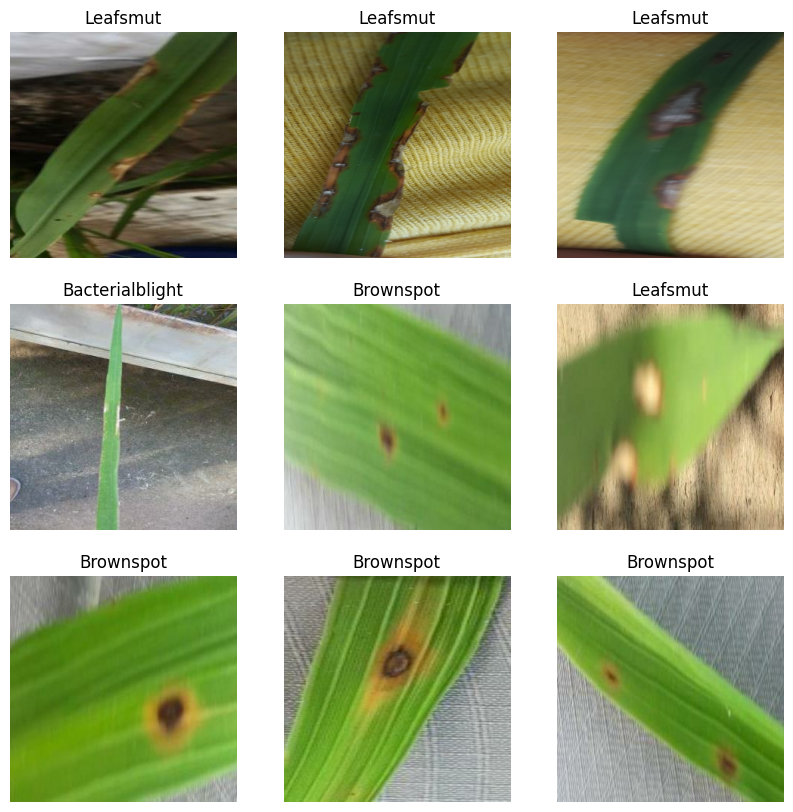

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

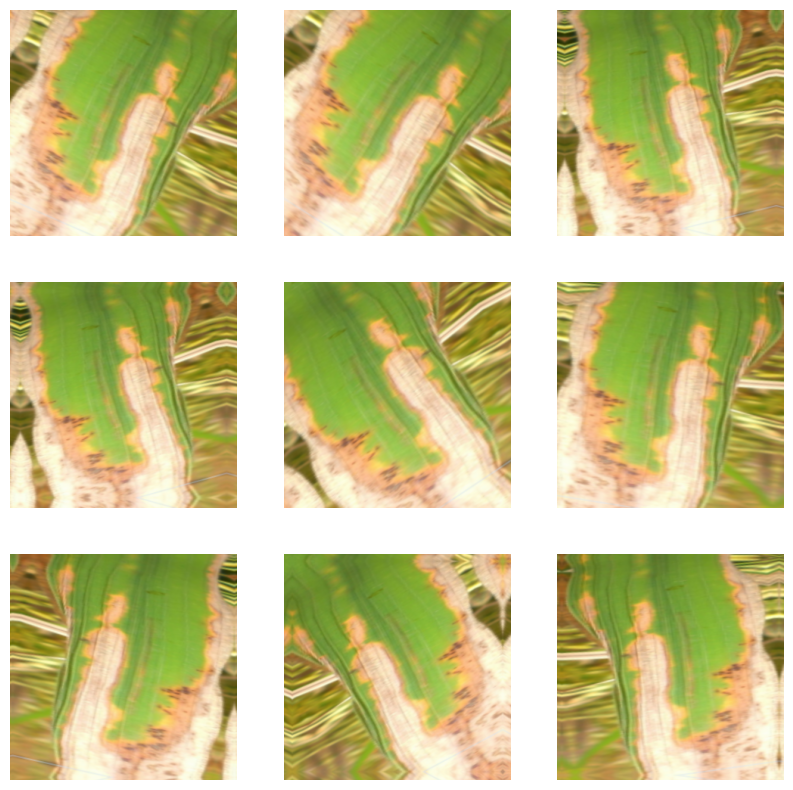

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height,img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                 

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


118/118 [==============================] - 188s 2s/step - loss: 0.8561 - accuracy: 0.6147 - val_loss: 0.6563 - val_accuracy: 0.7393
Epoch 2/5
118/118 [==============================] - 141s 1s/step - loss: 0.6001 - accuracy: 0.7695 - val_loss: 0.5185 - val_accuracy: 0.8152
Epoch 3/5
118/118 [==============================] - 152s 1s/step - loss: 0.4720 - accuracy: 0.8266 - val_loss: 0.4441 - val_accuracy: 0.8323
Epoch 4/5
118/118 [==============================] - 138s 1s/step - loss: 0.3724 - accuracy: 0.8535 - val_loss: 0.4565 - val_accuracy: 0.8130
Epoch 5/5
118/118 [==============================] - 133s 1s/step - loss: 0.3175 - accuracy: 0.8730 - val_loss: 0.2117 - val_accuracy: 0.9284


In [45]:
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print(f'Validation accuracy: {val_acc}')

30/30 - 11s - loss: 0.2117 - accuracy: 0.9284 - 11s/epoch - 359ms/step
Validation accuracy: 0.9284188151359558


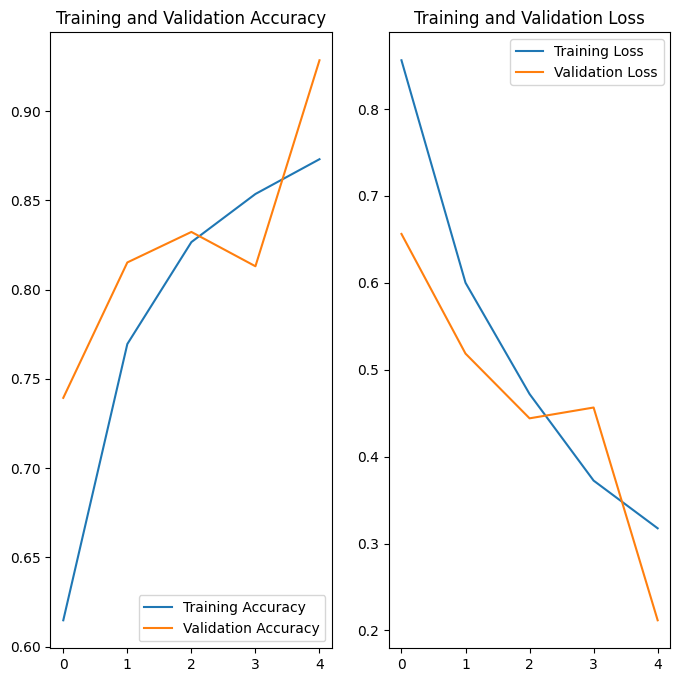

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()